# Nutrition dataset case study with multiple background samples showing confidence interval

In [2]:
# limit the number of threads used by xgboost models
import os
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=8                                                                                                               
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=8                                                                                                     
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=8                                                                                                               
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=8                                                                                                 
os.environ["NUMEXPR_NUM_THREADS"] = "8" # export NUMEXPR_NUM_THREADS=8         

# standard libaries
import sys
import copy
import dill
from collections import defaultdict
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# flow specific packages
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f
from flow import edge_credits2edge_credit
from on_manifold import OnManifoldExplainer, IndExplainer

# Dataset

In [3]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values
# remove the first column: unnamed: 0
X = X.iloc[:, 1:]
X_display = X_display.iloc[:, 1:]

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape, X_display.shape)
X.head()

(9932, 18) (9932, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


# Explaination Settings

In [4]:
n_bg = 100 # paper: 100, number of sampled background samples
nsamples = 100 # number of fg samples to explain
nruns = 1 # paper: 10,000, number of monte carlo samplings
bg = X.fillna(X.mean()).sample(n_bg) # background samples
sample_ind = 3 # sample to show

# Training

In [5]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=100)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model_train

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:7.26934
[100]	test-cox-nloglik:7.04554
[200]	test-cox-nloglik:6.90625
[300]	test-cox-nloglik:6.80909
[400]	test-cox-nloglik:6.73926
[500]	test-cox-nloglik:6.68686
[600]	test-cox-nloglik:6.64699
[700]	test-cox-nloglik:6.61571
[800]	test-cox-nloglik:6.59138
[900]	test-cox-nloglik:6.57148
[999]	test-cox-nloglik:6.55579


In [6]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 1000, evals = [(xgb_full, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:8.88081
[999]	test-cox-nloglik:8.16748


In [7]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8289463410825477

# Ind Shap

0it [00:00, ?it/s]


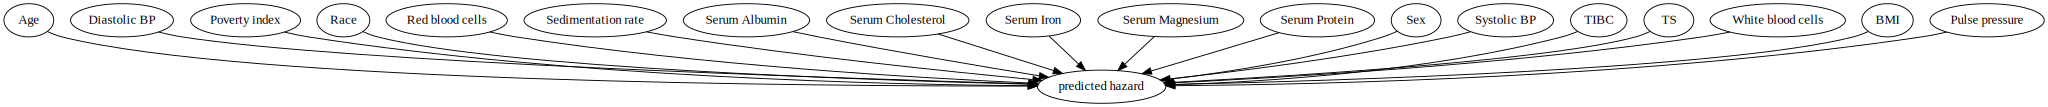

In [8]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model, output_margin=True)) # the target
graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)
graph.draw()

In [9]:
def node_dict2str_dict(node_edge_credit):
    res = defaultdict(lambda: defaultdict(int))
    for node1, d in node_edge_credit.items():
        for node2, val in d.items():
            res[node1.name][node2.name] = val
    return res

# multiple background result with individual run
edge_credits = [] # save for each run
for i in range(len(bg)): # average run result using linearity axiom
    print(f'bg {i}/{len(bg)}')
    for j in range(nruns):
        explainer = GraphExplainer(graph, bg[i:i+1], nruns=1) 
        cf = explainer.shap_values(X[:nsamples])
        edge_credits.append(node_dict2str_dict(cf.edge_credit)) # use node name is more portable vs. node

bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 0/100
bg 1/100


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


bg 2/100
bg 3/100
bg 4/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 5/100
bg 6/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 7/100
bg 8/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 9/100
bg 10/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 11/100
bg 12/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 13/100
bg 14/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 15/100
bg 16/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 17/100
bg 18/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 19/100
bg 20/100
bg 21/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 22/100
bg 23/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 24/100
bg 25/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 26/100
bg 27/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 28/100
bg 29/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 30/100
bg 31/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 32/100
bg 33/100


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


bg 34/100
bg 35/100
bg 36/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 37/100
bg 38/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 39/100
bg 40/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 41/100
bg 42/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 43/100
bg 44/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 45/100
bg 46/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 47/100
bg 48/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 49/100
bg 50/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 51/100
bg 52/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 53/100
bg 54/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 55/100
bg 56/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 57/100
bg 58/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 59/100
bg 60/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 61/100
bg 62/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 63/100
bg 64/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 65/100
bg 66/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 67/100
bg 68/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 69/100
bg 70/100


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


bg 71/100
bg 72/100
bg 73/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 74/100
bg 75/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 76/100
bg 77/100


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


bg 78/100
bg 79/100
bg 80/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 81/100
bg 82/100


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


bg 83/100
bg 84/100
bg 85/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 86/100
bg 87/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 88/100
bg 89/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 90/100
bg 91/100
bg 92/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 93/100
bg 94/100


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

bg 95/100
bg 96/100


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


bg 97/100
bg 98/100
bg 99/100


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


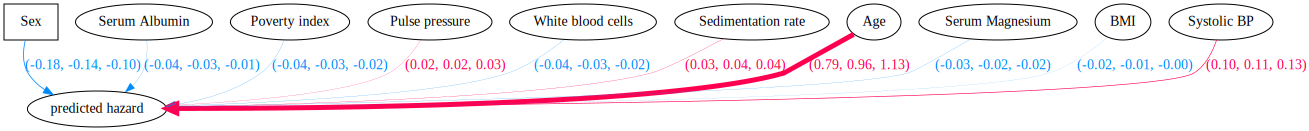

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f17721739c0>>

In [10]:
cf.show_CI = True # 95% confidence interval from https://link.springer.com/chapter/10.1007/978-3-030-57321-8_2 Equation 12.
cf.draw(sample_ind, max_display=10, edge_credit=edge_credits2edge_credit(edge_credits, cf.graph), show_fg_val=False)

# On manifold SHAP

In [12]:
feature_names = X.columns
f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x, columns=feature_names)), output_margin=True) # wrapper for the model used by on manifold explainer

# multiple background result with individual run
manifold_edge_credits = [] # save for each run
bg_on_manifold = X.fillna(X.mean()).sample(100) # used to learn conditional dependence
for i in range(len(bg)): # average run result using linearity axiom 
    print(f'bg {i}/{len(bg)}')
    for j in range(nruns):
        explainer = OnManifoldExplainer(f, pd.concat([bg[i:i+1], bg_on_manifold]), nruns=1, sigma_sq=1e-1, single_bg=True)
        cf_on_manifold = explainer.shap_values(X[:nsamples])
        manifold_edge_credits.append(cf_on_manifold) # use node name is more portable vs. node

  2%|▏         | 2/100 [00:00<00:06, 15.51it/s]

bg 0/100


  3%|▎         | 3/100 [00:00<00:04, 20.88it/s]

bg 1/100


  3%|▎         | 3/100 [00:00<00:04, 21.00it/s]

bg 2/100


  3%|▎         | 3/100 [00:00<00:04, 21.21it/s]

bg 3/100


  3%|▎         | 3/100 [00:00<00:04, 19.75it/s]

bg 4/100


  2%|▏         | 2/100 [00:00<00:06, 14.68it/s]

bg 5/100


  2%|▏         | 2/100 [00:00<00:06, 15.26it/s]

bg 6/100


  2%|▏         | 2/100 [00:00<00:06, 15.19it/s]

bg 7/100


  3%|▎         | 3/100 [00:00<00:04, 20.69it/s]

bg 8/100


  3%|▎         | 3/100 [00:00<00:04, 20.72it/s]

bg 9/100


  3%|▎         | 3/100 [00:00<00:04, 21.26it/s]

bg 10/100


  2%|▏         | 2/100 [00:00<00:06, 15.18it/s]

bg 11/100


  2%|▏         | 2/100 [00:00<00:06, 15.31it/s]

bg 12/100


  2%|▏         | 2/100 [00:00<00:07, 13.19it/s]

bg 13/100


  2%|▏         | 2/100 [00:00<00:06, 16.25it/s]

bg 14/100


  2%|▏         | 2/100 [00:00<00:06, 15.65it/s]

bg 15/100


  3%|▎         | 3/100 [00:00<00:04, 21.05it/s]

bg 16/100


  3%|▎         | 3/100 [00:00<00:04, 20.91it/s]

bg 17/100


  2%|▏         | 2/100 [00:00<00:05, 18.98it/s]

bg 18/100


  3%|▎         | 3/100 [00:00<00:04, 20.56it/s]

bg 19/100


  2%|▏         | 2/100 [00:00<00:05, 16.44it/s]

bg 20/100


  2%|▏         | 2/100 [00:00<00:06, 15.22it/s]

bg 21/100


  2%|▏         | 2/100 [00:00<00:06, 15.66it/s]

bg 22/100


  3%|▎         | 3/100 [00:00<00:04, 20.53it/s]

bg 23/100


  2%|▏         | 2/100 [00:00<00:06, 15.53it/s]

bg 24/100


  2%|▏         | 2/100 [00:00<00:05, 16.58it/s]

bg 25/100


  2%|▏         | 2/100 [00:00<00:06, 15.45it/s]

bg 26/100


  3%|▎         | 3/100 [00:00<00:04, 21.07it/s]

bg 27/100


  2%|▏         | 2/100 [00:00<00:07, 13.66it/s]

bg 28/100


  2%|▏         | 2/100 [00:00<00:06, 15.08it/s]

bg 29/100


  3%|▎         | 3/100 [00:00<00:04, 21.80it/s]

bg 30/100


  2%|▏         | 2/100 [00:00<00:05, 17.53it/s]

bg 31/100


  2%|▏         | 2/100 [00:00<00:05, 17.95it/s]

bg 32/100


  2%|▏         | 2/100 [00:00<00:07, 13.45it/s]

bg 33/100


  2%|▏         | 2/100 [00:00<00:07, 13.30it/s]

bg 34/100


  3%|▎         | 3/100 [00:00<00:04, 20.87it/s]

bg 35/100


  3%|▎         | 3/100 [00:00<00:04, 20.30it/s]

bg 36/100


  2%|▏         | 2/100 [00:00<00:05, 18.51it/s]

bg 37/100


  2%|▏         | 2/100 [00:00<00:05, 16.61it/s]

bg 38/100


  3%|▎         | 3/100 [00:00<00:04, 21.48it/s]

bg 39/100


  3%|▎         | 3/100 [00:00<00:04, 21.22it/s]

bg 40/100


  2%|▏         | 2/100 [00:00<00:05, 18.47it/s]

bg 41/100


  2%|▏         | 2/100 [00:00<00:05, 17.87it/s]

bg 42/100


  2%|▏         | 2/100 [00:00<00:04, 19.92it/s]

bg 43/100


  3%|▎         | 3/100 [00:00<00:04, 21.42it/s]

bg 44/100


  2%|▏         | 2/100 [00:00<00:06, 16.21it/s]

bg 45/100


  2%|▏         | 2/100 [00:00<00:06, 15.12it/s]

bg 46/100


  3%|▎         | 3/100 [00:00<00:04, 21.24it/s]

bg 47/100


  2%|▏         | 2/100 [00:00<00:06, 15.17it/s]

bg 48/100


  3%|▎         | 3/100 [00:00<00:04, 19.77it/s]

bg 49/100


  3%|▎         | 3/100 [00:00<00:04, 20.51it/s]

bg 50/100


  2%|▏         | 2/100 [00:00<00:06, 15.39it/s]

bg 51/100


  3%|▎         | 3/100 [00:00<00:04, 21.82it/s]

bg 52/100


  3%|▎         | 3/100 [00:00<00:04, 21.09it/s]

bg 53/100


  2%|▏         | 2/100 [00:00<00:06, 15.67it/s]

bg 54/100


  3%|▎         | 3/100 [00:00<00:04, 20.95it/s]

bg 55/100


  2%|▏         | 2/100 [00:00<00:04, 19.85it/s]

bg 56/100


  3%|▎         | 3/100 [00:00<00:04, 21.47it/s]

bg 57/100


  2%|▏         | 2/100 [00:00<00:06, 15.74it/s]

bg 58/100


  3%|▎         | 3/100 [00:00<00:04, 21.58it/s]

bg 59/100


  3%|▎         | 3/100 [00:00<00:04, 20.80it/s]

bg 60/100


  2%|▏         | 2/100 [00:00<00:06, 15.30it/s]

bg 61/100


  2%|▏         | 2/100 [00:00<00:06, 15.10it/s]

bg 62/100


  3%|▎         | 3/100 [00:00<00:04, 21.02it/s]

bg 63/100


  3%|▎         | 3/100 [00:00<00:04, 20.55it/s]

bg 64/100


  2%|▏         | 2/100 [00:00<00:05, 16.50it/s]

bg 65/100


  2%|▏         | 2/100 [00:00<00:06, 15.38it/s]

bg 66/100


  2%|▏         | 2/100 [00:00<00:07, 13.52it/s]

bg 67/100


  2%|▏         | 2/100 [00:00<00:07, 13.06it/s]

bg 68/100


  3%|▎         | 3/100 [00:00<00:04, 20.66it/s]

bg 69/100


  2%|▏         | 2/100 [00:00<00:07, 13.35it/s]

bg 70/100


  2%|▏         | 2/100 [00:00<00:07, 13.31it/s]

bg 71/100


  2%|▏         | 2/100 [00:00<00:06, 15.52it/s]

bg 72/100


  3%|▎         | 3/100 [00:00<00:04, 21.02it/s]

bg 73/100


  2%|▏         | 2/100 [00:00<00:06, 15.42it/s]

bg 74/100


  2%|▏         | 2/100 [00:00<00:06, 15.34it/s]

bg 75/100


  2%|▏         | 2/100 [00:00<00:05, 18.41it/s]

bg 76/100


  3%|▎         | 3/100 [00:00<00:04, 21.39it/s]

bg 77/100


  2%|▏         | 2/100 [00:00<00:06, 14.96it/s]

bg 78/100


  2%|▏         | 2/100 [00:00<00:05, 19.26it/s]

bg 79/100


  3%|▎         | 3/100 [00:00<00:04, 21.51it/s]

bg 80/100


  3%|▎         | 3/100 [00:00<00:04, 21.30it/s]

bg 81/100


  2%|▏         | 2/100 [00:00<00:06, 15.47it/s]

bg 82/100


  2%|▏         | 2/100 [00:00<00:06, 15.53it/s]

bg 83/100


  2%|▏         | 2/100 [00:00<00:04, 19.76it/s]

bg 84/100


  3%|▎         | 3/100 [00:00<00:04, 20.29it/s]

bg 85/100


  2%|▏         | 2/100 [00:00<00:07, 13.59it/s]

bg 86/100


  3%|▎         | 3/100 [00:00<00:04, 20.33it/s]

bg 87/100


  2%|▏         | 2/100 [00:00<00:06, 15.09it/s]

bg 88/100


  2%|▏         | 2/100 [00:00<00:06, 16.24it/s]

bg 89/100


  2%|▏         | 2/100 [00:00<00:06, 15.90it/s]

bg 90/100


  3%|▎         | 3/100 [00:00<00:04, 21.46it/s]

bg 91/100


  3%|▎         | 3/100 [00:00<00:04, 20.10it/s]

bg 92/100


  2%|▏         | 2/100 [00:00<00:07, 13.10it/s]

bg 93/100


  2%|▏         | 2/100 [00:00<00:07, 13.44it/s]

bg 94/100


  2%|▏         | 2/100 [00:00<00:06, 15.11it/s]

bg 95/100


  3%|▎         | 3/100 [00:00<00:04, 21.33it/s]

bg 96/100


  2%|▏         | 2/100 [00:00<00:05, 17.83it/s]

bg 97/100


  2%|▏         | 2/100 [00:00<00:07, 13.54it/s]

bg 98/100


  2%|▏         | 2/100 [00:00<00:05, 19.45it/s]

bg 99/100


100%|██████████| 100/100 [00:05<00:00, 19.97it/s]


On manifold


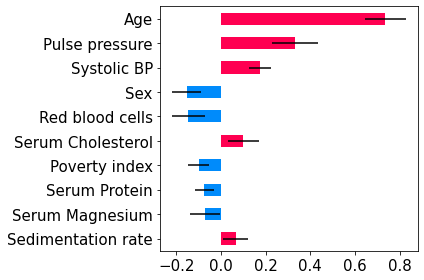

In [13]:
print('On manifold')
sum(manifold_edge_credits).draw(sample_ind, show=False, max_display=10)
plt.tight_layout()
plt.show()

# Shapley Flow

In [14]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model, output_margin=True)) # the target uses log(HR) instead of HR
A = ['Diastolic BP', 'Systolic BP']
D = ['Pulse pressure'] # Systolic BP - Diastolic BP
causal_links.add_causes_effects(A, D, lambda dbp, sdp: sdp-dbp)
A = ['Age', 'Sex', 'Poverty index', 'Race']
D = list(set(feature_names) - set(A) - set(['Pulse pressure']))
causal_links.add_causes_effects(A, D)
A = ['Age', 'Sex', 'Race']
D = ['Poverty index']
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)

learning dependency for White blood cells:   0%|          | 0/14 [00:00<?, ?it/s]

[0]	test-rmse:7.24529
[100]	test-rmse:6.04540
[200]	test-rmse:5.08526
[300]	test-rmse:4.32187
[400]	test-rmse:3.72444
[499]	test-rmse:3.26567


learning dependency for Serum Albumin:   7%|▋         | 1/14 [00:00<00:08,  1.48it/s]    

[0]	test-rmse:3.87407
[100]	test-rmse:3.17810
[200]	test-rmse:2.60949
[300]	test-rmse:2.14547
[400]	test-rmse:1.76748
[499]	test-rmse:1.46278


learning dependency for Serum Cholesterol:  14%|█▍        | 2/14 [00:01<00:07,  1.61it/s]

[0]	test-rmse:226.94263
[100]	test-rmse:187.87550
[200]	test-rmse:156.24817
[300]	test-rmse:130.78793
[400]	test-rmse:110.44482
[499]	test-rmse:94.44800


learning dependency for Diastolic BP:  21%|██▏       | 3/14 [00:01<00:06,  1.59it/s]     

[0]	test-rmse:83.71988
[100]	test-rmse:68.93323
[200]	test-rmse:56.90493
[300]	test-rmse:47.15287
[400]	test-rmse:39.27799
[499]	test-rmse:33.00833


learning dependency for BMI:  29%|██▊       | 4/14 [00:02<00:06,  1.60it/s]         

[0]	test-rmse:25.68026
[100]	test-rmse:21.22700
[200]	test-rmse:17.61862
[300]	test-rmse:14.70853
[400]	test-rmse:12.38153
[499]	test-rmse:10.55001


learning dependency for Serum Magnesium:  36%|███▌      | 5/14 [00:02<00:05,  1.65it/s]

[0]	test-rmse:1.18907
[100]	test-rmse:0.97714
[200]	test-rmse:0.80443
[300]	test-rmse:0.66402
[400]	test-rmse:0.55023
[499]	test-rmse:0.45920


learning dependency for Sedimentation rate:  43%|████▎     | 6/14 [00:03<00:04,  1.72it/s]

[0]	test-rmse:19.38453
[100]	test-rmse:16.95487
[200]	test-rmse:15.09857
[300]	test-rmse:13.70687
[400]	test-rmse:12.67748
[499]	test-rmse:11.94172


learning dependency for TS:  50%|█████     | 7/14 [00:04<00:04,  1.68it/s]                

[0]	test-rmse:29.79472
[100]	test-rmse:25.10775
[200]	test-rmse:21.40968
[300]	test-rmse:18.53344
[400]	test-rmse:16.33232
[499]	test-rmse:14.69491


learning dependency for Serum Iron:  57%|█████▋    | 8/14 [00:04<00:03,  1.65it/s]

[0]	test-rmse:105.80270
[100]	test-rmse:88.86579
[200]	test-rmse:75.45215
[300]	test-rmse:64.97789
[400]	test-rmse:56.92674
[499]	test-rmse:50.90213


learning dependency for Serum Protein:  64%|██████▍   | 9/14 [00:05<00:03,  1.65it/s]

[0]	test-rmse:6.61101
[100]	test-rmse:5.42027
[200]	test-rmse:4.44728
[300]	test-rmse:3.65281
[400]	test-rmse:3.00507
[499]	test-rmse:2.48216


learning dependency for Systolic BP:  71%|███████▏  | 10/14 [00:05<00:02,  1.86it/s]  

[0]	test-rmse:136.18751
[100]	test-rmse:112.07594
[200]	test-rmse:92.46082
[300]	test-rmse:76.55484
[400]	test-rmse:63.71541
[499]	test-rmse:53.49734


learning dependency for Red blood cells:  79%|███████▊  | 11/14 [00:06<00:01,  1.80it/s]

[0]	test-rmse:56.62017
[100]	test-rmse:47.20332
[200]	test-rmse:39.64856
[300]	test-rmse:33.63278
[400]	test-rmse:28.88806
[499]	test-rmse:25.23218


learning dependency for TIBC:  86%|████████▌ | 12/14 [00:06<00:01,  1.86it/s]           

[0]	test-rmse:365.08758
[100]	test-rmse:300.40857
[200]	test-rmse:247.82375
[300]	test-rmse:205.21208
[400]	test-rmse:170.85916
[499]	test-rmse:143.55502


learning dependency for Poverty index:  93%|█████████▎| 13/14 [00:07<00:00,  1.83it/s]

[0]	test-rmse:365.16959
[100]	test-rmse:325.23489
[200]	test-rmse:295.42532
[300]	test-rmse:273.60980
[400]	test-rmse:257.95938
[499]	test-rmse:247.04848


learning dependency for Poverty index: 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]


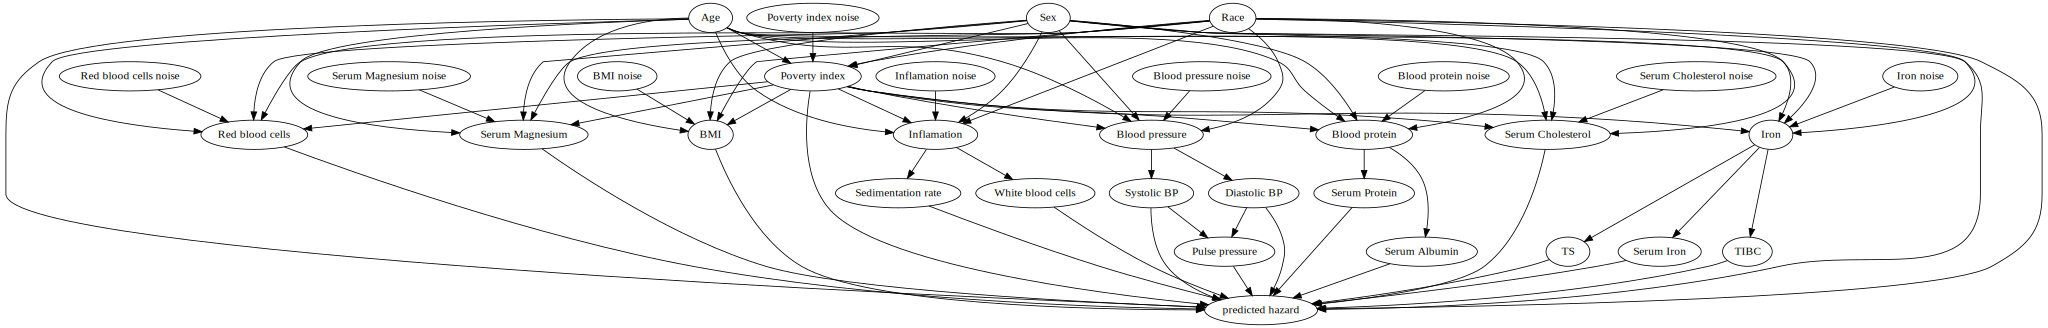

In [15]:
# for multiple baseline need to run this multiple times, finally I can just combine the different baselines because of linearity
E = GraphExplainer(causal_graph, bg[:1])
E.prepare_graph(X) # add noise node
G = copy.deepcopy(E.graph) # group happens after noise node b/c the grouped nodes combines individual noise node
G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')
G.draw()

In [16]:
# multiple background result with individual run
causal_edge_credits = [] # save for each run
for i in range(len(bg)): # average run result using linearity axiom
    print(f'bg {i}/{len(bg)}')
    for j in range(nruns):
        E = GraphExplainer(causal_graph, bg[i:i+1])
        E.prepare_graph(X) # add noise node
        G = copy.deepcopy(E.graph) # group happens after noise node b/c the grouped nodes combines individual noise node
        G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
        G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
        G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
        G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')

        explainer = GraphExplainer(G, bg[i:i+1], nruns=1) 
        cf_c = explainer.shap_values(X[:nsamples], skip_prepare=True)        
        causal_edge_credits.append(node_dict2str_dict(cf_c.edge_credit)) # use node name is more portable vs. node

bg 0/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.46s/it]


bg 1/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.89s/it]


bg 2/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.35s/it]


bg 3/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.62s/it]


bg 4/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.49s/it]


bg 5/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.97s/it]


bg 6/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.06s/it]


bg 7/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.88s/it]


bg 8/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.83s/it]


bg 9/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.09s/it]


bg 10/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.28s/it]


bg 11/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.59s/it]


bg 12/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.86s/it]


bg 13/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.76s/it]


bg 14/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.25s/it]


bg 15/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.33s/it]


bg 16/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.18s/it]


bg 17/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.22s/it]


bg 18/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.97s/it]


bg 19/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.39s/it]


bg 20/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.94s/it]


bg 21/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.30s/it]


bg 22/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.79s/it]


bg 23/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.27s/it]


bg 24/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.90s/it]


bg 25/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.95s/it]


bg 26/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.70s/it]


bg 27/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.40s/it]


bg 28/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


bg 29/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.96s/it]


bg 30/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.79s/it]


bg 31/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.69s/it]


bg 32/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.27s/it]


bg 33/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]


bg 34/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.65s/it]


bg 35/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.01s/it]


bg 36/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.50s/it]


bg 37/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00, 10.00s/it]


bg 38/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.25s/it]


bg 39/100


bruteforce sampling: 100%|██████████| 1/1 [00:08<00:00,  8.94s/it]


bg 40/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


bg 41/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.52s/it]


bg 42/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.96s/it]


bg 43/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.00s/it]


bg 44/100


bruteforce sampling: 100%|██████████| 1/1 [00:08<00:00,  8.98s/it]


bg 45/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.08s/it]


bg 46/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.11s/it]


bg 47/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.56s/it]


bg 48/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.15s/it]


bg 49/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.42s/it]


bg 50/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.26s/it]


bg 51/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.16s/it]


bg 52/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.16s/it]


bg 53/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.00s/it]


bg 54/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


bg 55/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.18s/it]


bg 56/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.50s/it]


bg 57/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]


bg 58/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.68s/it]


bg 59/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.48s/it]


bg 60/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.64s/it]


bg 61/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.12s/it]


bg 62/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.74s/it]


bg 63/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.05s/it]


bg 64/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.01s/it]


bg 65/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.81s/it]


bg 66/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.57s/it]


bg 67/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.23s/it]


bg 68/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.75s/it]


bg 69/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.87s/it]


bg 70/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.49s/it]


bg 71/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.69s/it]


bg 72/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.69s/it]


bg 73/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.22s/it]


bg 74/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.83s/it]


bg 75/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.88s/it]


bg 76/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.19s/it]


bg 77/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.40s/it]


bg 78/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.42s/it]


bg 79/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.02s/it]


bg 80/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


bg 81/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.49s/it]


bg 82/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.49s/it]


bg 83/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.61s/it]


bg 84/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.54s/it]


bg 85/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.32s/it]


bg 86/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.21s/it]


bg 87/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


bg 88/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.88s/it]


bg 89/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.42s/it]


bg 90/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.96s/it]


bg 91/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.30s/it]


bg 92/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.11s/it]


bg 93/100


bruteforce sampling: 100%|██████████| 1/1 [00:10<00:00, 10.10s/it]


bg 94/100


bruteforce sampling: 100%|██████████| 1/1 [00:11<00:00, 11.13s/it]


bg 95/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


bg 96/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]


bg 97/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.68s/it]


bg 98/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.76s/it]


bg 99/100


bruteforce sampling: 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]


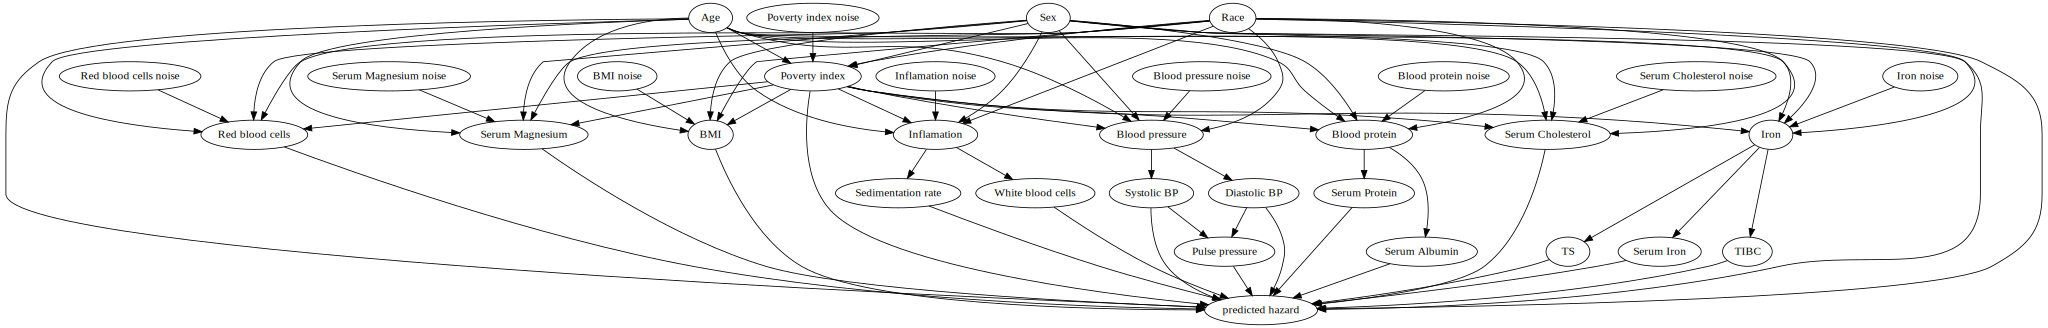

In [19]:
cf_c.graph.draw()

error Pulse pressure noise Pulse pressure -0.0054528713


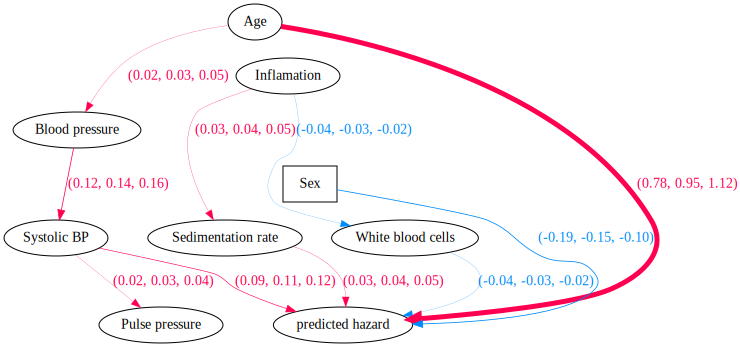

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f177242d240>>

In [35]:
cf_c.show_CI = True
cf_c.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

# Methods comparison: flow, independent, on-manifold, ASV

error Pulse pressure noise Pulse pressure -0.0054528713


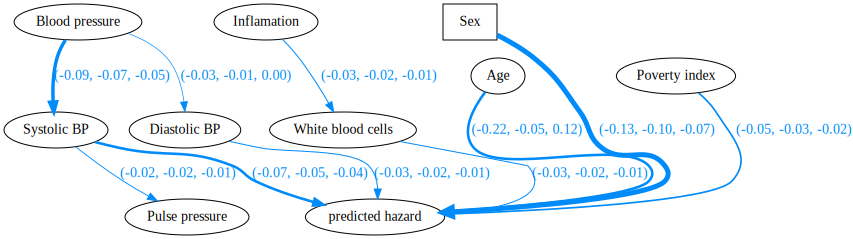

In [36]:
sample_ind = 99 # 35
cf_c.fold_noise = True # False
cf_c.show_CI = True
g = cf_c.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

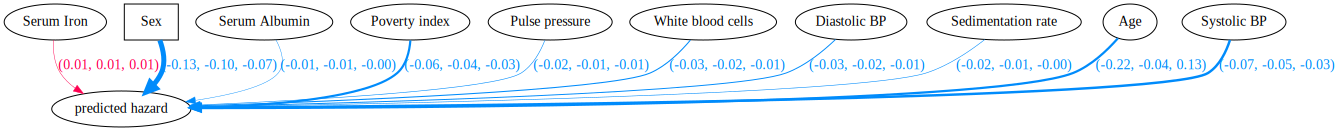

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f177242d780>>

In [37]:
cf.show_CI = True
cf.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=edge_credits2edge_credit(edge_credits, cf.graph))

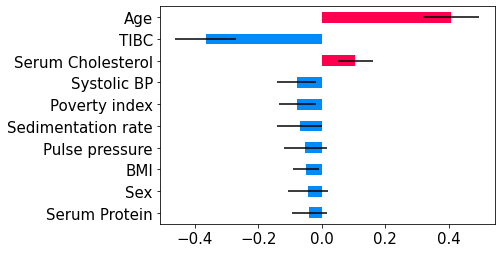

In [38]:
# cf_on_manifold.draw(sample_ind, max_display=10)
sum(manifold_edge_credits).draw(sample_ind, show=False, max_display=10)

error Pulse pressure noise Pulse pressure -0.0054528713


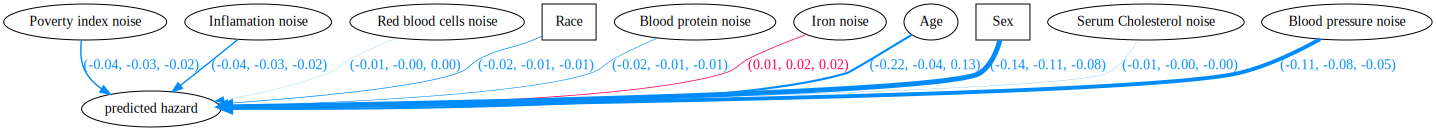

In [42]:
cf_c.fold_noise = False
cf_c.show_CI = True
g = cf_c.draw_asv(sample_ind, max_display=10, show_fg_val=False, flow_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

# investigate the background and foreground samples

In [39]:
pd.concat([X.mean(0), X_display.iloc[sample_ind]], 1).rename(columns={0: "mean", sample_ind: 'sample_ind'}).T

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
mean,49.4491,83.282,287.213,1.19603,54.8805,16.2683,4.3651,221.235,101.117,1.68131,7.10407,1.60723,134.854,362.605,28.5559,7.45176,25.6898,51.5755
sample_ind,51,74,824,1,77.7,9,4.3,267,63,1.61,6.8,Female,118,503,12.5,4.4,23.589,44


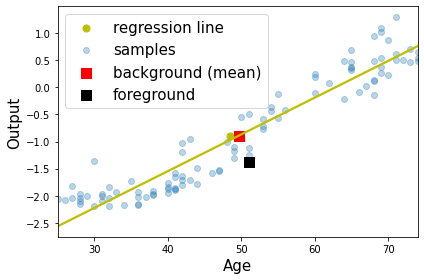

In [40]:
o = f(np.array(X)[:nsamples])

xlabel = 'Age'
ylabel = 'Output'

sns.regplot(X[xlabel][:nsamples], o, x_bins=1, order=1, ci=None, label='regression line', color='y')
plt.scatter(X[xlabel][:nsamples], o, alpha=0.3, label='samples')
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
# plt.scatter(X[xlabel][[0]], o[[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][:100].mean(), o.mean(), c=['red'], s=100, marker='s', label='background (mean)')
plt.scatter(X[xlabel][[sample_ind]], o[[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

Increasing the age, increases log hazard.

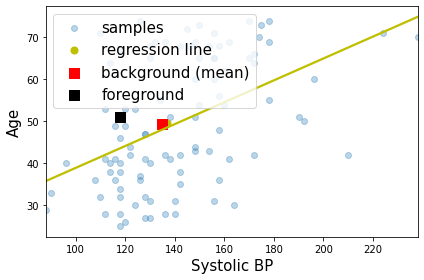

In [41]:
o = f(np.array(X)[:nsamples])

def normalize(o): # normalize to 0-1
    return (o - o.min()) / (o.max() - o.min())

ylabel = 'Age'
xlabel = 'Systolic BP' #'Serum Magnesium'

plt.scatter(X[xlabel][:nsamples], X[ylabel][:nsamples],
            alpha=0.3, label='samples')
sns.regplot(X[xlabel][:nsamples], X[ylabel][:nsamples], x_bins=1, order=1, ci=None, label='regression line', color='y')
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)

plt.scatter(X[xlabel].mean(), X[ylabel].mean(), c=['red'], s=100, marker='s', label='background (mean)')
plt.scatter(X[xlabel][[sample_ind]], X[ylabel][[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15, loc="upper left")

plt.tight_layout()
# plt.savefig(f'figures/manifold_multiple_explain_age_{xlabel}_{sample_ind}.png')
plt.show()

Updating Systolic BP before Age would cause the expeted age to decrease, thus greating inflating the risk of Age for this sample